# Parkinson's Disease Detection Using Keystroke Data

### Team 1:
   * Bojan Ristovski
   * Valentina Angelovska



**Introduction**:

* Parkinson's Disease (PD) is a progressive neurodegenerative disorder that affects millions of people worldwide. Early detection of PD is crucial for timely intervention and management of the disease. In this project, we aim to develop a machine learning model capable of detecting Parkinson's Disease based on keystroke data. By analyzing patterns in keystrokes, we seek to provide a non-invasive and cost-effective method for screening individuals for PD.


**Dataset Information:**

* The dataset used in this project consists of two zip files: "ArchivedUsers.zip" and "TappyData.zip". These files contain text files containing general information about users and their keystroke patterns. The dataset has been preprocessed to include only users with "Mild" impact and those with a minimum of 30 keystrokes.

ArchivedUsers.zip: https://www.mediafire.com/file/ytinaz8nsapy6j9/ArchivedUsers.zip/file

TappyData.zip: https://www.mediafire.com/file/d7s40qiglfbs8xt/TappyData.zip/file

In [2]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
from datetime import datetime
import pickle
import joblib


#Utility Libraries
import os
from google.colab import drive
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from numba import njit, prange, jit
from IPython.display import IFrame, display

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#Preprocessing and hyperparameter tuning
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV,learning_curve,GridSearchCV
from sklearn.model_selection import cross_val_score,KFold,train_test_split,cross_validate
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import plotly.graph_objs as go

# Models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report,confusion_matrix
from tabulate import tabulate

np.random.seed(42)


### Read Data


In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Paths to the folders in Google Drive
archived_users_folder = '/content/drive/MyDrive/Final Project/ArchivedUsers'
tappy_data_folder = '/content/drive/MyDrive/Final Project/TappyData'

# List all files from the folders
archived_users_files = os.listdir(archived_users_folder)
tappy_data_files= os.listdir(tappy_data_folder)

Mounted at /content/drive


In [4]:
# Empty list for data storage
archived_users_list = []

# Iterate over each file in the folder
for file_name in archived_users_files:
  # checking if the file is in txt format
    if file_name.endswith('.txt'):
      # extract file name code to use it later as userkey
        file_name_code = file_name.split('_')[1].split('.')[0]
        file_path = os.path.join(archived_users_folder, file_name)
        with open(file_path, 'r') as file:
            # read each line of the file
            lines = file.readlines()
            # print(lines)
            # dictionary to store data from files
            user_data = {}
            # extract data from each line
            for line in lines:
                # split the line into key and value based on ':'
                #because every row in the txt file is in form birthyear: 1995
                key_value = line.strip().split(': ')
                # Check if the line contains key-value pair
                if len(key_value) == 2:
                    key, value = key_value
                    user_data[key] = value
            # Append the file name code to the dictionary
            user_data['UserKey'] = file_name_code
            # Append the user data to the list
            archived_users_list.append(user_data)


# Create a DataFrame
archived_users_df = pd.DataFrame(archived_users_list)

archived_users_df.head()

,BirthYear,Gender,Parkinsons,Tremors,DiagnosisYear,Sided,UPDRS,Impact,Levadopa,DA,MAOB,Other,UserKey
0,1959,Female,False,False,------,None,Don't know,------,False,False,False,False,0QAZFRHQHW
1,1944,Male,False,False,------,None,Don't know,------,False,False,False,False,1HOEBIGASW
2,1936,Male,False,False,------,None,Don't know,------,False,False,False,False,1XNJCXS3EY
3,1936,Male,False,False,------,None,Don't know,------,False,False,False,False,3DIXPRIOSW
4,NaN,Male,False,False,------,None,Don't know,------,False,False,False,False,4XPHKKBXS6


In [ ]:
# Empty list for data storage
tappy_data_list = []

# Iterate over each file in the folder
for file_name in tappy_data_files:
    # Check if the file is in txt format
    if file_name.endswith('.txt'):
        file_path = os.path.join(tappy_data_folder, file_name)
        with open(file_path, 'r') as file:
            # Read each line of the file
            for line in file:
                try:
                    # Split the line into columns based on tab
                    columns = line.strip().split('\t')
                    # Ensure the line has the correct number of columns
                    if len(columns) == 8:
                        tappy_data_list.append(columns)
                except Exception as e:
                    # Skip lines with errors
                    print(f"Error processing line: {e}")
                    continue

# Create a DataFrame from the list of data
tappy_data_df = pd.DataFrame(tappy_data_list,
                             columns=['UserKey', 'Date', 'Timestamp',
                                      'Hand', 'Hold_time', 'Direction',
                                      'Latency_time', 'Flight_time'])

# Display the DataFrame
tappy_data_df.head()

,UserKey,Date,Timestamp,Hand,Hold_time,Direction,Latency_time,Flight_time
0,0QAZFRHQHW,160916,19:20:43.891,L,0078.1,LL,0312.5,0257.8
1,0QAZFRHQHW,160916,19:20:44.344,L,0078.1,LL,0453.1,0375.0
2,0QAZFRHQHW,160916,19:20:44.742,L,0062.5,LL,0414.1,0335.9
3,0QAZFRHQHW,160916,19:20:45.516,L,0093.8,LL,0742.2,0679.7
4,0QAZFRHQHW,160916,19:20:46.047,R,0101.6,LR,0523.4,0429.7


# Data Preprocessing

In [ ]:
# Checking for unique values for each columns in archived users
for column in archived_users_df.columns:
    print(f'For {column} unique values are: {len(archived_users_df[column].unique())}')

For BirthYear unique values are: 38
For Gender unique values are: 2
For Parkinsons unique values are: 2
For Tremors unique values are: 2
For DiagnosisYear unique values are: 18
For Sided unique values are: 3
For UPDRS unique values are: 1
For Impact unique values are: 2
For Levadopa unique values are: 2
For DA unique values are: 2
For MAOB unique values are: 2
For Other unique values are: 2
For UserKey unique values are: 113


In [ ]:
# Checking unique values for each column in tappy dataframe
for column in tappy_data_df.columns:
    print(f'For {column} unique values are: {len(tappy_data_df[column].unique())}')

For UserKey unique values are: 134
For Date unique values are: 280
For Timestamp unique values are: 4017661
For Hand unique values are: 60
For Hold_time unique values are: 1817
For Direction unique values are: 53
For Latency_time unique values are: 3233
For Flight_time unique values are: 3087


In [ ]:
# Calculating overlapping users and not matching users
archived_user_keys = set(archived_users_df['UserKey'].unique())
tappy_user_keys = set(tappy_data_df['UserKey'].unique())

overlapping_users = archived_user_keys.intersection(tappy_user_keys)
not_matching_user_ids = tappy_user_keys - archived_user_keys

print('Overlapping users:', len(overlapping_users))
print('Number of not matching user ids:', len(not_matching_user_ids))

Overlapping users: 113
Number of not matching user ids: 21


In [ ]:
# Cleaning archived users data

# Replace values starting with '-' with NaN
def replace_dash(x):
    if str(x).startswith(' -'):
        return np.nan
    else:
        return x

for col in archived_users_df.columns:
    if any(archived_users_df[col].astype(str).str.startswith(' -')):
        archived_users_df[col] = archived_users_df[col].apply(replace_dash)


# Dropping UPRDS because its not containing important informations
archived_users_df.drop(columns=['UPDRS'], inplace=True)

# We have users that have Parkinsons = False and Tremors=True, DiagnosisYear and Sided
# We will change those patients to True

filtered_df = archived_users_df[(archived_users_df['Parkinsons'] == False) & (archived_users_df['Tremors'] == True)]
archived_users_df.loc[filtered_df.index, 'Parkinsons'] = True

# Change Impact values Nan with None (None in users without parkinson disease)
archived_users_df['Impact'] = archived_users_df['Impact'].replace(np.nan,'None')

archived_users_df.tail()

,BirthYear,Gender,Parkinsons,Tremors,DiagnosisYear,Sided,Impact,Levadopa,DA,MAOB,Other,UserKey
108,1948,Male,False,False,NaN,None,None,False,False,False,False,YQSGN9BMVK
109,1953,Female,True,True,2016,Right,Mild,False,False,False,False,YWMIQIQND3
110,1928,Male,False,False,NaN,None,None,False,False,False,False,YYPKGX6B24
111,1947,Female,True,True,2015,Right,Mild,False,False,False,True,Z2UPVHHGBE
112,1942,Male,True,False,2016,None,Mild,True,False,False,False,ZWBPPNQCUX


In [ ]:
# Changing datatypes
archived_users_types = {
    'BirthYear': 'Int64',
    'DiagnosisYear': 'Int64',
    'Gender': 'string',
    'Sided': 'string',
    'Impact': 'string'}

tappy_data_types = {
    'Date': {'dtype': 'datetime64[ns]', 'format': '%y%m%d'},
    'Timestamp': {'dtype': 'datetime64[ns]', 'format' : '%H:%M:%S.%f'},
    'Hold_time': 'float',
    'Latency_time': 'float',
    'Flight_time': 'float'}

# Convert data types for archived_users_df
archived_users_df = archived_users_df.astype(archived_users_types)

# Convert data types for tappy_data_df
for col, dtype_info in tappy_data_types.items():
    if isinstance(dtype_info, dict): #checks if the variable dtype_info is dict
        tappy_data_df[col] = pd.to_datetime(tappy_data_df[col],
                                            format=dtype_info['format'],
                                            errors='coerce')
    elif dtype_info == 'string':
        tappy_data_df[col] = tappy_data_df[col].astype('string')
    else:
        tappy_data_df[col] = pd.to_numeric(tappy_data_df[col], errors='coerce')


# Boolean columns
boolean_columns = ['Parkinsons', 'Tremors', 'Levadopa', 'DA', 'MAOB', 'Other']

# Convert specified columns to boolean
for column in boolean_columns:
    archived_users_df[column] = archived_users_df[column].map({'True': True,
                                                               'False': False})

In [ ]:
# Cleaning tappy data

# Define Lengths of features (this way the cleaning goes quicker)
column_lengths = {
    'UserKey': None,
    'Hand': 1,
    'Direction': 2}

# Filter UserKey length
tappy_data_df = tappy_data_df[(tappy_data_df['UserKey'].str.len() > 3)
                              & (tappy_data_df['UserKey'].str.len() < 25)]

# Filter the DataFrame to remove inconsistencies based on specified column lengths
for column, length in column_lengths.items():
    if length is not None:
        tappy_data_df = tappy_data_df[tappy_data_df[column].str.len() == length]

# Drop null values
tappy_data_df.dropna(inplace=True)

# Identify UserKeys in tappy_data_df that are not in archived_users_df
non_matching_users = tappy_data_df[~tappy_data_df['UserKey'].isin(archived_users_df['UserKey'])]['UserKey'].unique()

# Remove rows with non-matching UserKeys from tappy_data_df
tappy_data_df = tappy_data_df[~tappy_data_df['UserKey'].isin(non_matching_users)]

# Drop rows where Hand == S and Direction == LS, RS, SS, SL, RL
values_to_remove = ['RS', 'SL', 'SR', 'LS', 'SS']

# Condition for removing
conditions = (tappy_data_df['Hand'] == 'S') | (tappy_data_df['Direction'].isin(values_to_remove))

# Drop rows based on the conditions
tappy_data_df = tappy_data_df[~conditions]

# Shape of tappy data dataframe
print('Shape of tappy data dataframe:',tappy_data_df.shape)

Shape of tappy data dataframe: (3266866, 8)


**Note:**

The reason why we excluded rows where Hand == S and Direction == [LS, RS, SS, SL, RL] is because these combinations provided irrelevant data for our analysis.

### Missing Values

In [ ]:
# For tappy data
tappy_data_df.isnull().sum()

UserKey         0
Date            0
Timestamp       0
Hand            0
Hold_time       0
Direction       0
Latency_time    0
Flight_time     0
dtype: int64

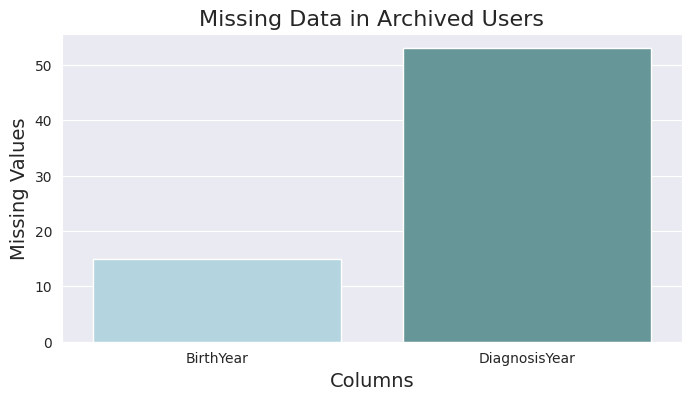

In [ ]:
# Missing values visualisations for Archived users

# Counting Null values
missing_data_users = archived_users_df.isnull().sum()
missing_data_users = missing_data_users[missing_data_users > 0]

#set up colors
custom_colors = ['lightblue', 'cadetblue']

#Set up the plot
plt.figure(figsize=(8, 4))
sns.set_style('darkgrid')

sns.barplot(x=missing_data_users.index, y=missing_data_users.values,
            hue=missing_data_users.index, palette=custom_colors)
plt.legend().remove()

plt.xlabel('Columns', fontsize=14)
plt.ylabel('Missing Values', fontsize=14)
plt.title('Missing Data in Archived Users', fontsize=16)

plt.show()

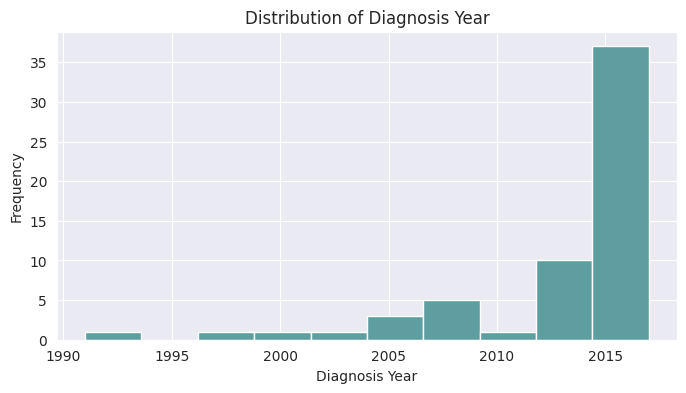

In [ ]:
# Distribution of the 'DiagnosisYear' column
diagnosis_year_values = archived_users_df['DiagnosisYear'].dropna()

# Plot
plt.figure(figsize=(8, 4))

plt.hist(diagnosis_year_values, color = 'cadetblue')
plt.title('Distribution of Diagnosis Year')
plt.xlabel('Diagnosis Year')
plt.ylabel('Frequency')

plt.show()

As observed, there are no remaining missing values in the Tappy data, but some missing values persist in the archived users' data. For patients with missing diagnosis years who have Parkinson's disease, we will populate these years using random selection due to the absence of a normal distribution, which prevents us from using the mean or median for imputation.

Regarding the BirthYear column, we have decided not to populate its missing values since it will not be used in our further analysis.

In [ ]:
# Population of DiagnosisYear for patient with Parkinson desease using random

#extract non null values
non_null_values = archived_users_df['DiagnosisYear'].dropna()

size = len(archived_users_df[(archived_users_df['Parkinsons'] == 'True')
                              & (archived_users_df['DiagnosisYear'].isnull())])

#random sampling
random_samples = np.random.choice(non_null_values,
                                  size=size,
                                  replace=True)
#condition
condition = (archived_users_df['Parkinsons'] == 'True') & (archived_users_df['DiagnosisYear'].isnull())

#apply condition
archived_users_df.loc[condition, 'DiagnosisYear'] = random_samples

# Diagnosis Year for those patients that don't have Parkinson's will be filled with -1 value
archived_users_df['DiagnosisYear'] = archived_users_df['DiagnosisYear'].fillna(-1)

#checking if there are left patients not populated
archived_users_df[(archived_users_df['Parkinsons'] == 'True')
                              & (archived_users_df['DiagnosisYear'].isnull())]

,BirthYear,Gender,Parkinsons,Tremors,DiagnosisYear,Sided,Impact,Levadopa,DA,MAOB,Other,UserKey


### Outliers

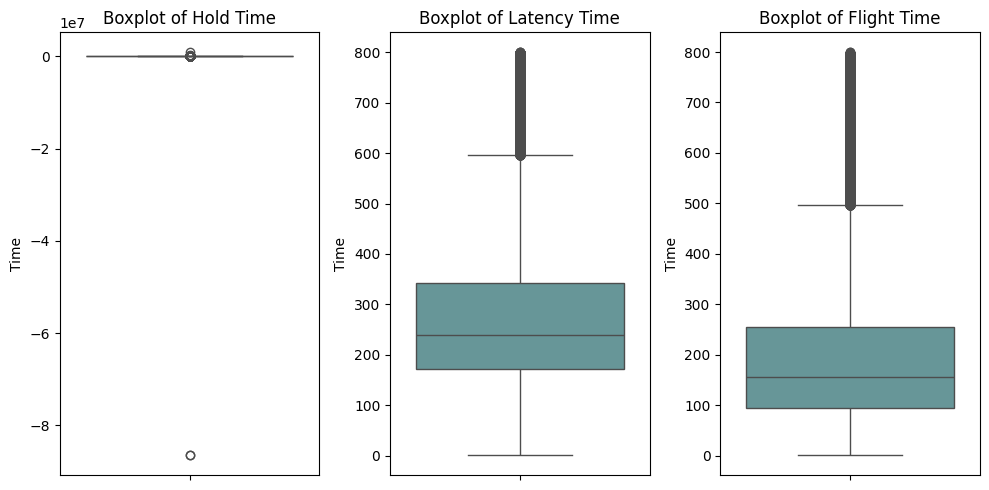

In [ ]:
# Outliers visualisation with boxplots
plt.figure(figsize=(10, 5))

# Boxplot for Hold_time
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
sns.boxplot(data=tappy_data_df['Hold_time'], color = 'cadetblue')
plt.title('Boxplot of Hold Time')
plt.ylabel('Time')

# Boxplot for Latency_time
plt.subplot(1, 3, 2)
sns.boxplot(data=tappy_data_df['Latency_time'], color='cadetblue')
plt.title('Boxplot of Latency Time')
plt.ylabel('Time')

# Boxplot for Flight_time
plt.subplot(1, 3, 3)
sns.boxplot(data=tappy_data_df['Flight_time'], color='cadetblue')
plt.title('Boxplot of Flight Time')
plt.ylabel('Time')

plt.tight_layout()
plt.show()


In [ ]:
# Calculate the mean and standard deviation for Hold Time column
mean = tappy_data_df['Hold_time'].mean()
std_dev = tappy_data_df['Hold_time'].std()

# Define the thresholds for outliers
lower_bound = mean - 3 * std_dev
upper_bound = mean + 3 * std_dev

# Identify outliers
outliers_ht = tappy_data_df[(tappy_data_df['Hold_time'] < lower_bound) | (tappy_data_df['Hold_time'] > upper_bound)]
display(outliers_ht)

# Remove outliers because there are only 3
tappy_data_df = tappy_data_df[(tappy_data_df['Hold_time'] >= lower_bound) & (tappy_data_df['Hold_time'] <= upper_bound)]

,UserKey,Date,Timestamp,Hand,Hold_time,Direction,Latency_time,Flight_time
4047242,SDZPQV3VZ1,2016-11-25,1900-01-01 00:00:00.092,R,-86399700.0,LR,148.4,468.8
4438613,VVYPNRQ5KG,2016-12-06,1900-01-01 00:00:00.048,R,-86399920.0,RR,250.0,148.4
4494141,WXNQ0QM0XD,2017-02-25,1900-01-01 10:20:04.117,R,812648.4,LR,82.0,152.3


In [ ]:
# Calculate the mean and standard deviation for Latency Time column
mean = tappy_data_df['Latency_time'].mean()
std_dev = tappy_data_df['Latency_time'].std()

# Define the thresholds for outliers
lower_bound = mean - 3 * std_dev
upper_bound = mean + 3 * std_dev

# Identify outliers
outliers_lt = tappy_data_df[(tappy_data_df['Latency_time'] < lower_bound) | (tappy_data_df['Latency_time'] > upper_bound)]
display(outliers_lt)

,UserKey,Date,Timestamp,Hand,Hold_time,Direction,Latency_time,Flight_time
3,0QAZFRHQHW,2016-09-16,1900-01-01 19:20:45.516,L,93.8,LL,742.2,679.7
15,0QAZFRHQHW,2016-09-18,1900-01-01 10:51:24.375,L,89.8,LL,722.7,632.8
52,0QAZFRHQHW,2016-09-18,1900-01-01 15:07:03.750,L,105.5,LL,753.9,652.3
91,0QAZFRHQHW,2016-09-19,1900-01-01 21:12:52.797,L,140.6,LL,695.3,562.5
93,0QAZFRHQHW,2016-09-19,1900-01-01 21:12:53.984,L,125.0,RL,726.6,593.8
...,...,...,...,...,...,...,...,...
4715062,Z2UPVHHGBE,2017-03-03,1900-01-01 20:42:52.703,R,218.8,LR,734.4,507.8
4715184,Z2UPVHHGBE,2017-03-03,1900-01-01 20:50:24.930,R,125.0,LR,734.4,484.4
4715275,Z2UPVHHGBE,2017-03-03,1900-01-01 20:51:08.969,R,125.0,LR,781.3,656.3
4715519,Z2UPVHHGBE,2017-03-03,1900-01-01 20:52:55.031,R,132.8,LR,765.6,640.6


In [ ]:
# Calculate the mean and standard deviation for Flight Time column
mean = tappy_data_df['Flight_time'].mean()
std_dev = tappy_data_df['Flight_time'].std()

# Define the thresholds for outliers
lower_bound = mean - 3 * std_dev
upper_bound = mean + 3 * std_dev

# Identify outliers
outliers_ft = tappy_data_df[(tappy_data_df['Flight_time'] < lower_bound) | (tappy_data_df['Flight_time'] > upper_bound)]
display(outliers_ft)

,UserKey,Date,Timestamp,Hand,Hold_time,Direction,Latency_time,Flight_time
3,0QAZFRHQHW,2016-09-16,1900-01-01 19:20:45.516,L,93.8,LL,742.2,679.7
15,0QAZFRHQHW,2016-09-18,1900-01-01 10:51:24.375,L,89.8,LL,722.7,632.8
42,0QAZFRHQHW,2016-09-18,1900-01-01 15:06:38.598,R,121.1,LR,668.0,601.6
52,0QAZFRHQHW,2016-09-18,1900-01-01 15:07:03.750,L,105.5,LL,753.9,652.3
93,0QAZFRHQHW,2016-09-19,1900-01-01 21:12:53.984,L,125.0,RL,726.6,593.8
...,...,...,...,...,...,...,...,...
4715275,Z2UPVHHGBE,2017-03-03,1900-01-01 20:51:08.969,R,125.0,LR,781.3,656.3
4715340,Z2UPVHHGBE,2017-03-03,1900-01-01 20:51:34.680,R,187.5,LR,468.8,687.5
4715478,Z2UPVHHGBE,2017-03-03,1900-01-01 20:52:29.781,R,234.4,LR,125.0,765.6
4715519,Z2UPVHHGBE,2017-03-03,1900-01-01 20:52:55.031,R,132.8,LR,765.6,640.6


### Note:

For Flight Time and Latency Time columns, we decided not to remove outliers.  Medical datasets often require domain expertise and thorough investigation to understand the context and significance of outliers.

Instead of removing outliers, we'll use models known for their robustness to outliers. This approach allows us to preserve potentially valuable information while reducing the impact of outliers on our analyses and model performance.


In [ ]:
# Statistics
tappy_data_df.describe()[['Hold_time','Latency_time','Flight_time']].T

,count,mean,min,25%,50%,75%,max,std
Hold_time,3266863.0,111.695434,0.0,78.1,101.6,140.6,184847.7,142.425046
Latency_time,3266863.0,269.457994,1.0,171.9,238.3,341.8,799.9,138.766239
Flight_time,3266863.0,189.519556,1.0,93.8,156.3,254.9,799.1,131.249868


In [ ]:
#Remove negative and zero values from Hold_time column
tappy_data_df = tappy_data_df[tappy_data_df['Hold_time'] > 0]

# Filter values for Hold Time > 999 and drop them
tappy_data_df = tappy_data_df[tappy_data_df['Hold_time'] < 999]


# Exploratory Data Analysis

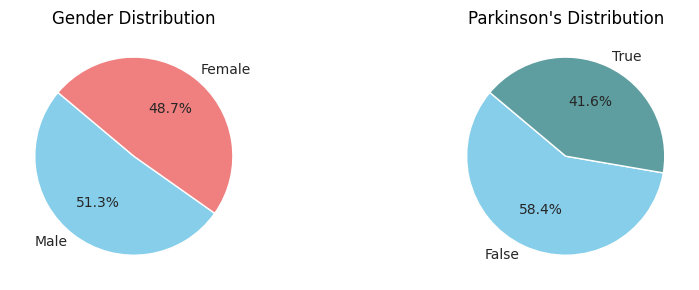

In [ ]:
#Visualisations
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

sns.set_style('darkgrid')

custom_colors_gender = ['skyblue', 'lightcoral']
custom_colors_parkinsons = ['skyblue', 'cadetblue']

# Gender pie chart
gender_counts = archived_users_df.Gender.value_counts()
axes[0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%',
               startangle=140, colors=custom_colors_gender)
axes[0].set_title('Gender Distribution')

# Parkinson's pie chart
patient_counts = archived_users_df.Parkinsons.value_counts()
axes[1].pie(patient_counts, labels=['False', 'True'], autopct='%1.1f%%',
               startangle=140, colors=custom_colors_parkinsons)
axes[1].set_title("Parkinson's Distribution")

# Show
plt.tight_layout()
plt.show()


What we can see from this plots is the following:

In our dataset of archived users, females represent 48.7%, while males comprise 51.3%. Regarding Parkinson's disease diagnosis, approximately 41.6% of users have received such a diagnosis, leaving 58.4% without. This distribution indicates a balance within the dataset, mainly balanced target feature Parkinson's

___________________________________________

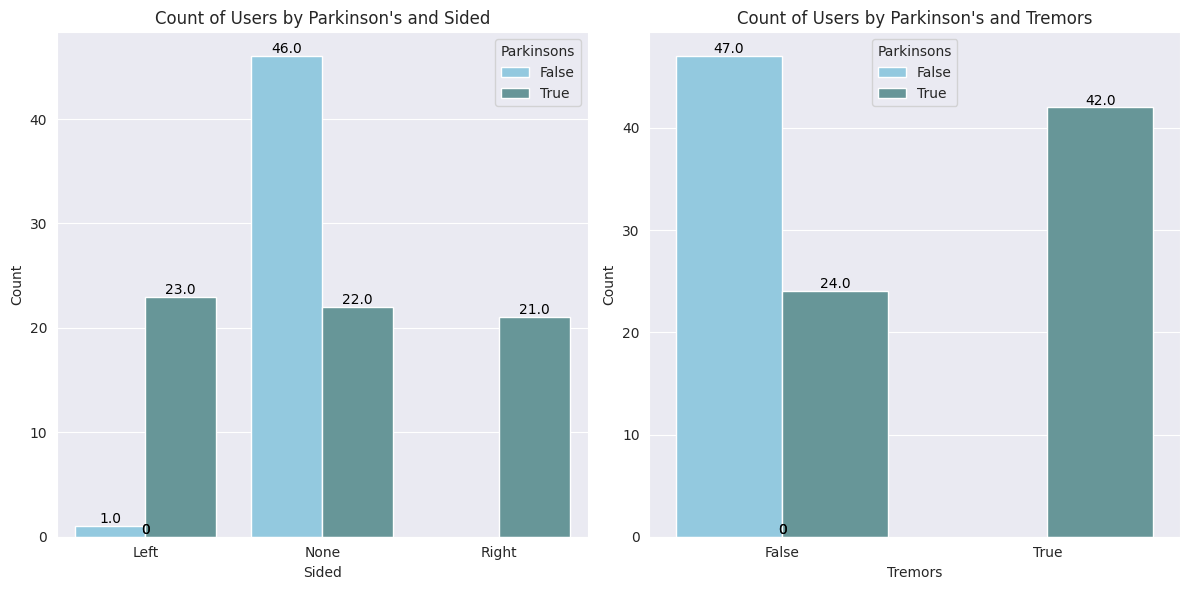

In [ ]:
# Number of patients by Sided and Tremors
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.set_style('darkgrid')

#custom colors
custom_colors = ['skyblue', 'cadetblue']

# Count of Users by Parkinson's and Gender
grouped_df_sided = archived_users_df.groupby(['Parkinsons', 'Sided']).size().reset_index(name='count')

sns.barplot(data=grouped_df_sided, x='Sided', y='count',
            hue='Parkinsons',palette=custom_colors, ax=axes[0])

# add values
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                     textcoords='offset points')

axes[0].set_title("Count of Users by Parkinson's and Sided")
axes[0].set_xlabel('Sided')
axes[0].set_ylabel('Count')
axes[0].legend(title='Parkinsons')

# Count of Users by Parkinson's and Tremors
grouped_df_tremors = archived_users_df.groupby(['Parkinsons', 'Tremors']).size().reset_index(name='count')

sns.barplot(data=grouped_df_tremors, x='Tremors', y='count',
            hue='Parkinsons',palette=custom_colors ,ax=axes[1])

#add values
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                     textcoords='offset points')

axes[1].set_title("Count of Users by Parkinson's and Tremors")
axes[1].set_xlabel('Tremors')
axes[1].set_ylabel('Count')
axes[1].legend(title='Parkinsons', bbox_to_anchor=(0.5, 1), loc='upper center')

# Show
plt.tight_layout()
plt.show()


From these plots, we can conclude the following:

The first bar plot illustrates the distribution of users based on two categorical variables: their Parkinson's diagnosis status (True or False) and the presence of a sided condition (Left, Right, or None). There's only one user without a Parkinson's diagnosis who exhibits a sided condition, specifically on the left side(maybe this is human mistake when populating the informations, but we will leave it as it is). There are users diagnosed with Parkinson's who do not exhibit any sided condition.

In the second bar plot, users are categorized by their Parkinson's diagnosis status ('True' or 'False') and the presence of tremors ('True' or 'False'). Here, we note the presence of distinct groups: users without Parkinson's disease who also lack tremors, users with both Parkinson's disease and tremors, and users without tremors despite having Parkinson's disease.

These observations highlight the connections between Parkinson's disease, gender, and tremor presence among our users. They offer valuable insights that can deepen our analysis and understanding of these factors.

___________________

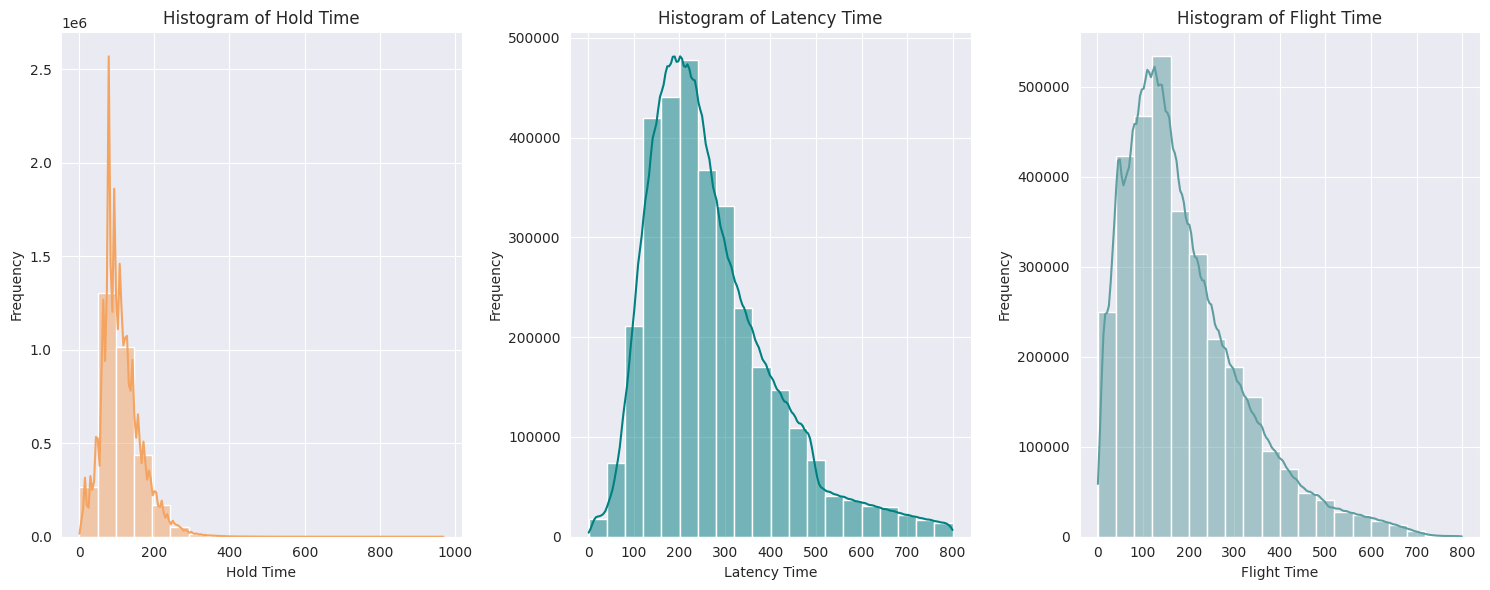

In [ ]:
# Histograms for Tappy data variables
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
sns.histplot(data=tappy_data_df, x='Hold_time',
             kde=True, bins=20, color='sandybrown')
plt.title('Histogram of Hold Time')
plt.xlabel('Hold Time')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(data=tappy_data_df, x='Latency_time',
             kde=True, bins=20, color='teal')
plt.title('Histogram of Latency Time')
plt.xlabel('Latency Time')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(data=tappy_data_df, x='Flight_time',
             kde=True, bins=20, color='cadetblue')
plt.title('Histogram of Flight Time')
plt.xlabel('Flight Time')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

From these histograms, we can draw several conclusions:

* Hold Time Distribution:

  The histogram of hold time illustrates the distribution of hold durations for keystrokes.
  We observe the frequency of different hold time intervals, with the majority of keystrokes falling within the range from 1 to 600.
  This distribution provides insights into the typical duration of keystrokes during user interactions.

* Latency Time Distribution:

  The histogram of latency time depicts the distribution of latency durations between keystrokes.
  It highlights the frequency of various latency time intervals, indicating the time intervals between consecutive keystrokes.
  Understanding latency time distribution is crucial for assessing the rhythm and pace of user interactions.

* Flight Time Distribution:

  Flight time histogram showcases the distribution of flight durations, representing the time intervals between the release of one keystroke and the pressing of the next.
  Similar to hold time and latency time, it provides insights into the temporal dynamics of user interactions.

We will focus only on Hold time and Latency time for further exploration and modeling.








# Feature Extraction

To help us extract features effectively, we use the following methods and integrations for these reasons:

* Custom Statistical Functions (@njit):

  These are fast functions to calculate mean, standard deviation, skewness, and kurtosis of data.
  
* Calculate Statistics Function:

  This function uses the custom statistical functions to find various stats (like mean, skewness) for hold time and latency time.
  
  
* Calculate Mean function

  This function is used to calculate mean for hold time and latency time when grouped by Hand and Direction.
  
  
* Sliding Window Function:

  It processes keystroke data for each user and date in chunks (sliding windows), calculating statistics for each chunk.
  It breaks down stats by direction ('LL', 'LR', etc.) and globally for each user.
  Results are collected and returned as a DataFrame.
  
  
* TQDM Integration:

  It adds a progress bar to show the processing status, making it easier to track progress when analyzing large datasets.

In [ ]:
# Define custom statistics functions with numba's njit for performance optimization
@njit
def custom_mean(data):
    return np.sum(data) / len(data)

@njit
def custom_std(data, mean):
    return np.sqrt(np.sum((data - mean) ** 2) / len(data))

@njit
def custom_skew(data, mean, std):
    return np.sum(((data - mean) / std) ** 3) / len(data)

@njit
def custom_kurtosis(data, mean, std):
    return np.sum(((data - mean) / std) ** 4) / len(data) - 3

@njit
def calculate_statistics(hold_time, latency_time):
    hold_time_mean = custom_mean(hold_time)
    hold_time_std = custom_std(hold_time, hold_time_mean)
    hold_time_skewness = custom_skew(hold_time, hold_time_mean, hold_time_std)
    hold_time_kurtosis = custom_kurtosis(hold_time, hold_time_mean, hold_time_std)

    latency_time_mean = custom_mean(latency_time)
    latency_time_std = custom_std(latency_time, latency_time_mean)
    latency_time_skewness = custom_skew(latency_time, latency_time_mean, latency_time_std)
    latency_time_kurtosis = custom_kurtosis(latency_time, latency_time_mean, latency_time_std)

    return {
        'HoldTimeMean': hold_time_mean,
        'HoldTimeStd': hold_time_std,
        'HoldTimeSkewness': hold_time_skewness,
        'HoldTimeKurtosis': hold_time_kurtosis,
        'LatencyTimeMean': latency_time_mean,
        'LatencyTimeStd': latency_time_std,
        'LatencyTimeSkewness': latency_time_skewness,
        'LatencyTimeKurtosis': latency_time_kurtosis
    }

# define separate function to calculate mean for direction and hand columns
@njit
def calculate_mean_statistics(hold_time, latency_time):
    hold_time_mean = custom_mean(hold_time)
    latency_time_mean = custom_mean(latency_time)

    return {
        'HoldTimeMean': hold_time_mean,
        'LatencyTimeMean': latency_time_mean
    }


# Initialize a dictionary with all possible keys set to None
template_stats = {}
for hand in ['L', 'R']:
    template_stats[f'{hand}_HoldTimeMean'] = None
    template_stats[f'{hand}_LatencyTimeMean'] = None

for direction in ['LL', 'LR', 'RL', 'RR']:
    template_stats[f'{direction}_HoldTimeMean'] = None
    template_stats[f'{direction}_LatencyTimeMean'] = None

for stat in calculate_statistics(np.array([0.0]), np.array([0.0])).keys():
    template_stats[f'Global_{stat}'] = None


# Define sliding window function
def sliding_window(tappy_data, time_window=5*60, step_size=1, keystroke_window=30):
    results = []

    # Group tappy_data by user and date and sort values by Timestamp(not necessary)
    for user_key, user_data in tqdm(tappy_data.groupby('UserKey'), desc="Processing Users"):

        window_counter = 0  # Window counter

        for date, date_data in user_data.groupby('Date'):
            data = date_data.sort_values(by='Timestamp')

            # create lists of values for each data
            timestamps = data['Timestamp'].values
            hold_time = data['Hold_time'].values
            latency_time = data['Latency_time'].values
            directions = data['Direction'].values
            hand = data['Hand'].values

            # sliding window definition
            for i in prange(0, len(data) - keystroke_window + 1, step_size):
                start_time = timestamps[i]
                end_time = timestamps[i + keystroke_window - 1]

                time_diff = (end_time - start_time).astype('timedelta64[s]').astype(int)

                # if the difference in time is smaller than time window defined than create mini df(lists) that have
                # values from that sliding window
                if time_diff < time_window:
                    window_indices = slice(i, i + keystroke_window)
                    window_hold_time = hold_time[window_indices]
                    window_latency_time = latency_time[window_indices]
                    window_directions = directions[window_indices]
                    window_hand = hand[window_indices]

                    # calculate global statistics for that time window
                    global_stats = calculate_statistics(window_hold_time, window_latency_time)

                    # group by hand and calculate statistics
                    hand_stats = {}
                    for h in np.unique(window_hand):
                        hand_indices = np.where(window_hand == h)
                        hand_hold_time = window_hold_time[hand_indices]
                        hand_latency_time = window_latency_time[hand_indices]
                        hand_stats[h] = calculate_mean_statistics(hand_hold_time, hand_latency_time)

                    # group by direction and calculate statistics
                    direction_stats = {}
                    for direction in np.unique(window_directions):
                        direction_indices = np.where(window_directions == direction)
                        direction_hold_time = window_hold_time[direction_indices]
                        direction_latency_time = window_latency_time[direction_indices]
                        direction_stats[direction] = calculate_mean_statistics(direction_hold_time, direction_latency_time)

                    # Calculate mean differences
                    mean_diff_LR_RL_LatencyTime = direction_stats.get('LR', {}).get('LatencyTimeMean', 0) - direction_stats.get('RL', {}).get('LatencyTimeMean', 0)
                    mean_diff_LL_RR_LatencyTime = direction_stats.get('LL', {}).get('LatencyTimeMean', 0) - direction_stats.get('RR', {}).get('LatencyTimeMean', 0)
                    mean_diff_L_R_HoldTime = hand_stats.get('L', {}).get('HoldTimeMean', 0) - hand_stats.get('R', {}).get('HoldTimeMean', 0)

                    # create dictionary to store statistics
                    agg_stats = template_stats.copy()

                    # Apply results in agg_stats for hand and direction
                    for h in ['L', 'R']:
                        stats_h = hand_stats.get(h, {})
                        if len(stats_h) > 0:
                            agg_stats.update({f'{h}_HoldTimeMean': stats_h.get('HoldTimeMean', None)})
                            agg_stats.update({f'{h}_LatencyTimeMean': stats_h.get('LatencyTimeMean', None)})

                    for direction in ['LL', 'LR', 'RL', 'RR']:
                        stats = direction_stats.get(direction, {})
                        if len(stats) > 0:
                            agg_stats.update({f'{direction}_HoldTimeMean': stats.get('HoldTimeMean', None)})
                            agg_stats.update({f'{direction}_LatencyTimeMean': stats.get('LatencyTimeMean', None)})


                    # update dictionary of stats with global statistics
                    agg_stats.update({f'Global_{stat}': global_stats.get(stat, None) for stat in global_stats.keys()})

                    # Append the calculated mean differences to agg_stats
                    agg_stats['mean_diff_LR_RL_LatencyTime'] = mean_diff_LR_RL_LatencyTime
                    agg_stats['mean_diff_LL_RR_LatencyTime'] = mean_diff_LL_RR_LatencyTime
                    agg_stats['mean_diff_L_R_HoldTime'] = mean_diff_L_R_HoldTime

                    # append the results to a list
                    results.append((user_key, window_counter) + tuple(agg_stats.values()))

                    # increase counter by 1
                    window_counter += 1

    columns = ['UserKey','Window_ID'] + list(template_stats.keys()) + ['mean_diff_LR_RL_LatencyTime', 'mean_diff_LL_RR_LatencyTime', 'mean_diff_L_R_HoldTime']
    return pd.DataFrame(results, columns=columns)

In [ ]:
#Apply sliding window function with 30 keystrokes and stepsize 1
results1 = sliding_window(tappy_data_df, time_window=5*60,step_size=1, keystroke_window=30)

Processing Users: 100%|██████████| 113/113 [21:07<00:00, 11.22s/it]


In [ ]:
# Nan values after applying sliding window function
results1.isna().sum().sum() / len(results1) * 100

2.1863053479767074

After applying the sliding window function only 2% of the values are NaN. These NaN values result from grouping by Hand and Direction. In some cases, certain Hands were not used during some time windows (sessions), leading to these NaN values.
That's why we decided to drop this values and continue with further analysis.

In [ ]:
# Dropping NaN values
results1 = results1.dropna()

In [ ]:
# Checking for lost users
not_in_results1 = ~tappy_data_df['UserKey'].isin(results1['UserKey'])

# Filter UserKeys from tappy_data_df based on the boolean mask
missing_user_keys = tappy_data_df['UserKey'][not_in_results1]

print(missing_user_keys.unique())

['E0TBSMYHQI' 'QPEDAXESTL' 'RYQGAPGNAM' 'ZWBPPNQCUX']


### Merging tappy data with archived users


Before merging these two dataframes, we'll create a new dataframe called "users" containing only the necessary columns: "UserKey" as the identifier, "Parkinsons" as the label, "Tremors" which is crucial for detecting Parkinson's disease, and "Sided" which is also important feature. Than we are going to encode these values and merge both dataframes.

In [ ]:
# Encode Parkinsons,Tremors(False -> 0, True -> 1) and Sided (None -> 0, Left -> 1, Right -> 2)
users = archived_users_df[['UserKey', 'Parkinsons', 'Tremors', 'Sided']]

# Encode Parkinsons and Tremors columns
users['Parkinsons'] = users['Parkinsons'].map({False: 0, True: 1})
users['Tremors'] = users['Tremors'].map({False: 0, True: 1})

# Encode Sided column
sided_mapping = {'None': 0, 'Left': 1, 'Right': 2}
users['Sided'] = users['Sided'].map(sided_mapping)

users.head()

,UserKey,Parkinsons,Tremors,Sided
0,0QAZFRHQHW,0,0,0
1,1HOEBIGASW,0,0,0
2,1XNJCXS3EY,0,0,0
3,3DIXPRIOSW,0,0,0
4,4XPHKKBXS6,0,0,0


In [ ]:
# Perform left join to merge users and results1 on UserKey
final_df = pd.merge(results1, users, on='UserKey', how='left')

# Shape of merged_df
final_df.shape

(2483196, 28)

In [ ]:
# Save final df
file_path = '/content/drive/MyDrive/Final Project/final.csv'

# Save the file on Google Drive
final_df.to_csv(file_path, index=False)

#### Load data

In [5]:
file_path = '/content/drive/MyDrive/Final Project/final.csv'

final_df = pd.read_csv(file_path)

In [ ]:
# Shape of our data
final_df.shape

(2483128, 28)

In [ ]:
# Final checking
final_df.isna().sum().sum()

0

### Final Visualisations

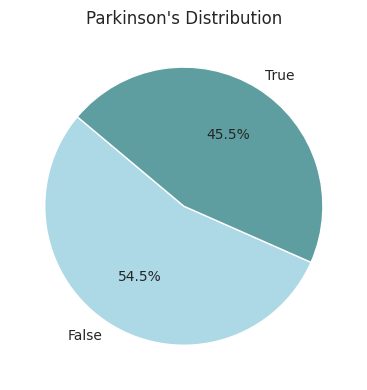

In [ ]:
# Target Balance after applying sliding window
patient_counts = final_df.Parkinsons.value_counts()

#custom colors
custom_colors = ['lightblue','cadetblue']

#plot
plt.figure(figsize = (8,4))

plt.pie(patient_counts, labels=['False', 'True'], autopct='%1.1f%%',
               startangle=140, colors=custom_colors)

plt.title("Parkinson's Distribution")

# Show
plt.tight_layout()
plt.show()

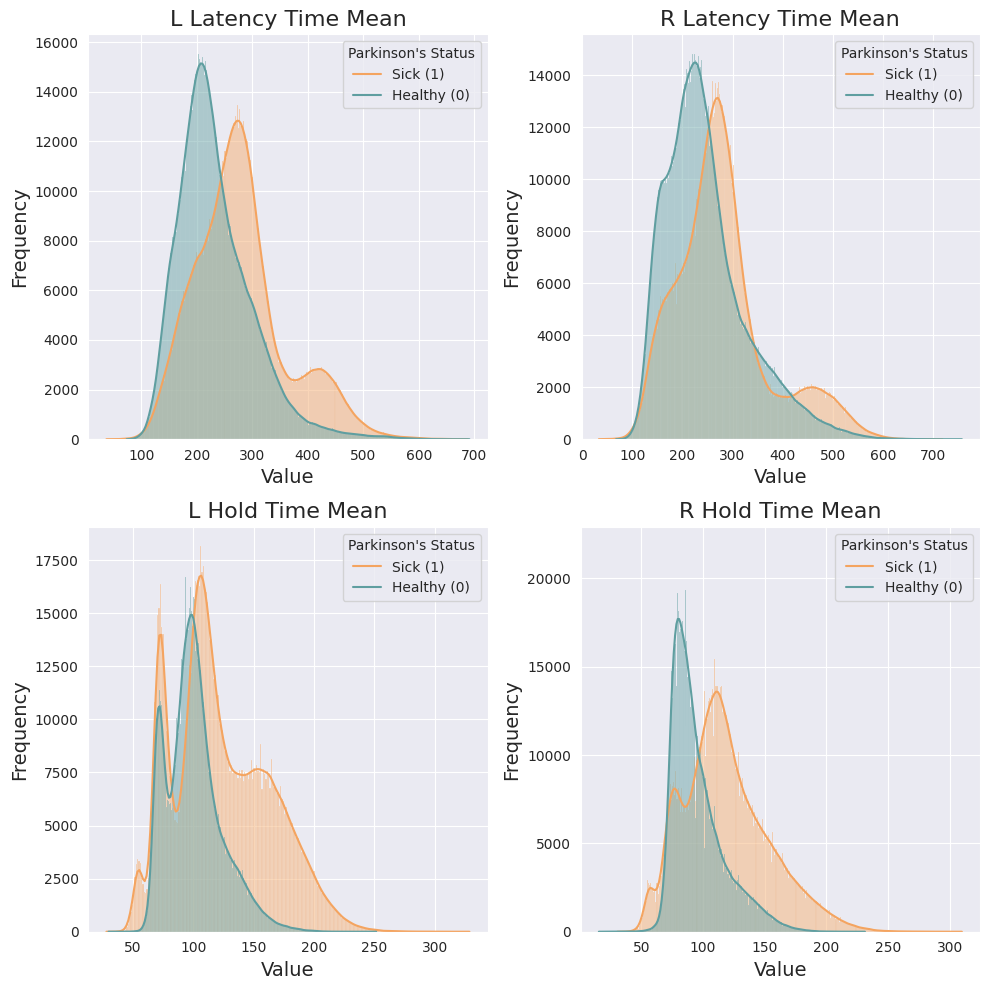

In [ ]:
# Parkinson's status comparasion with Left and Right Hand Patients

# Separate the data
sick = final_df[final_df['Parkinsons'] == 1]
healthy = final_df[final_df['Parkinsons'] == 0]

# Plot each feature comparison
plt.figure(figsize=(10, 10))

features = ['L_LatencyTimeMean', 'R_LatencyTimeMean', 'L_HoldTimeMean', 'R_HoldTimeMean']
titles = ['L Latency Time Mean', 'R Latency Time Mean', 'L Hold Time Mean', 'R Hold Time Mean']

for i, (feature, title) in enumerate(zip(features, titles), 1):
    plt.subplot(2, 2, i)
    sns.histplot(sick[feature], kde=True, color='sandybrown', label='Sick')
    sns.histplot(healthy[feature], kde=True, color='cadetblue', label='Healthy')
    plt.title(title, fontsize=16)
    plt.xlabel('Value', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend(title='Parkinson\'s Status', labels=['Sick (1)', 'Healthy (0)'])
    plt.tight_layout()

plt.show()

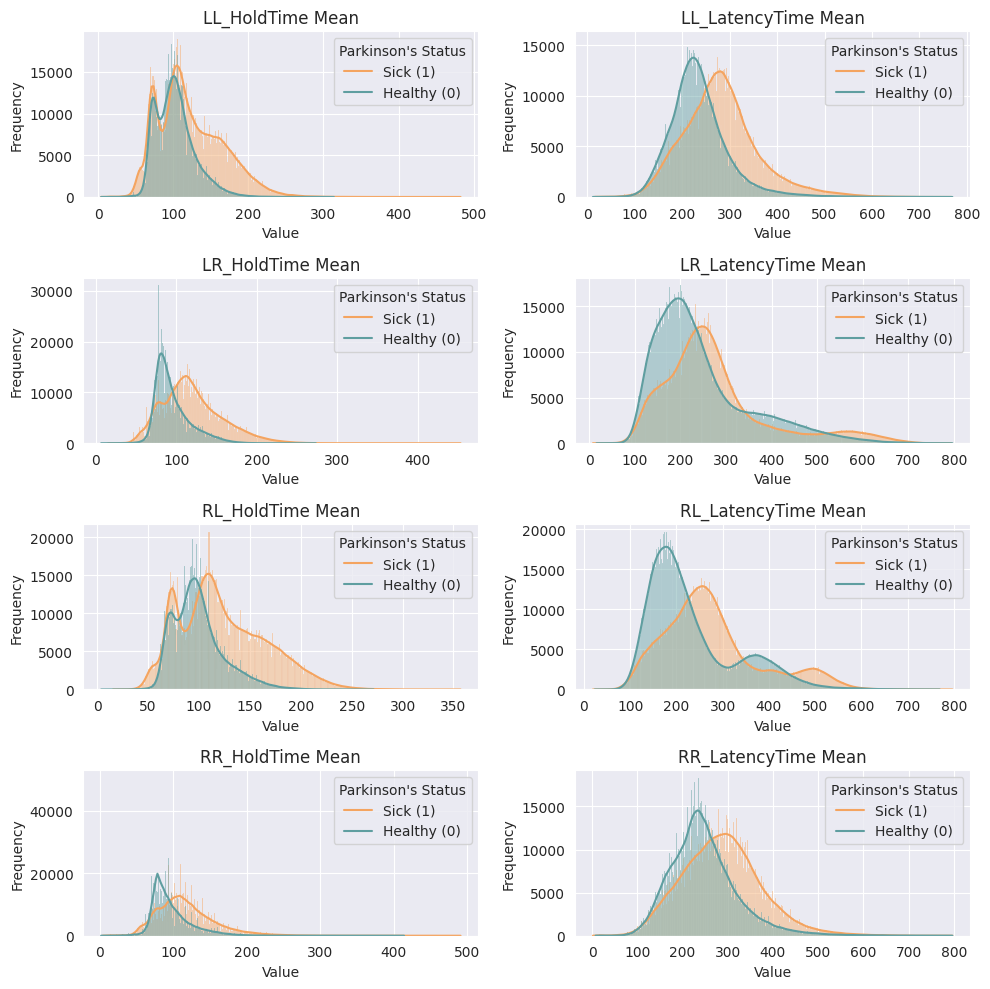

In [ ]:
# Parkinson's status comparasion with Directions

# Separate the data
sick = final_df[final_df['Parkinsons'] == 1]
healthy = final_df[final_df['Parkinsons'] == 0]

# Plot each feature comparison
plt.figure(figsize=(10, 10))

features = ['LL_HoldTimeMean',
       'LL_LatencyTimeMean', 'LR_HoldTimeMean', 'LR_LatencyTimeMean',
       'RL_HoldTimeMean', 'RL_LatencyTimeMean', 'RR_HoldTimeMean',
       'RR_LatencyTimeMean']

titles = ['LL_HoldTime Mean',
       'LL_LatencyTime Mean', 'LR_HoldTime Mean', 'LR_LatencyTime Mean',
       'RL_HoldTime Mean', 'RL_LatencyTime Mean', 'RR_HoldTime Mean',
       'RR_LatencyTime Mean']

for i, (feature, title) in enumerate(zip(features, titles), 1):
    plt.subplot(4, 2, i)
    sns.histplot(sick[feature], kde=True, color='sandybrown', label='Sick')
    sns.histplot(healthy[feature], kde=True, color='cadetblue', label='Healthy')
    plt.title(title, fontsize=12)
    plt.xlabel('Value', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.legend(title='Parkinson\'s Status', labels=['Sick (1)', 'Healthy (0)'])
    plt.tight_layout()

plt.show()

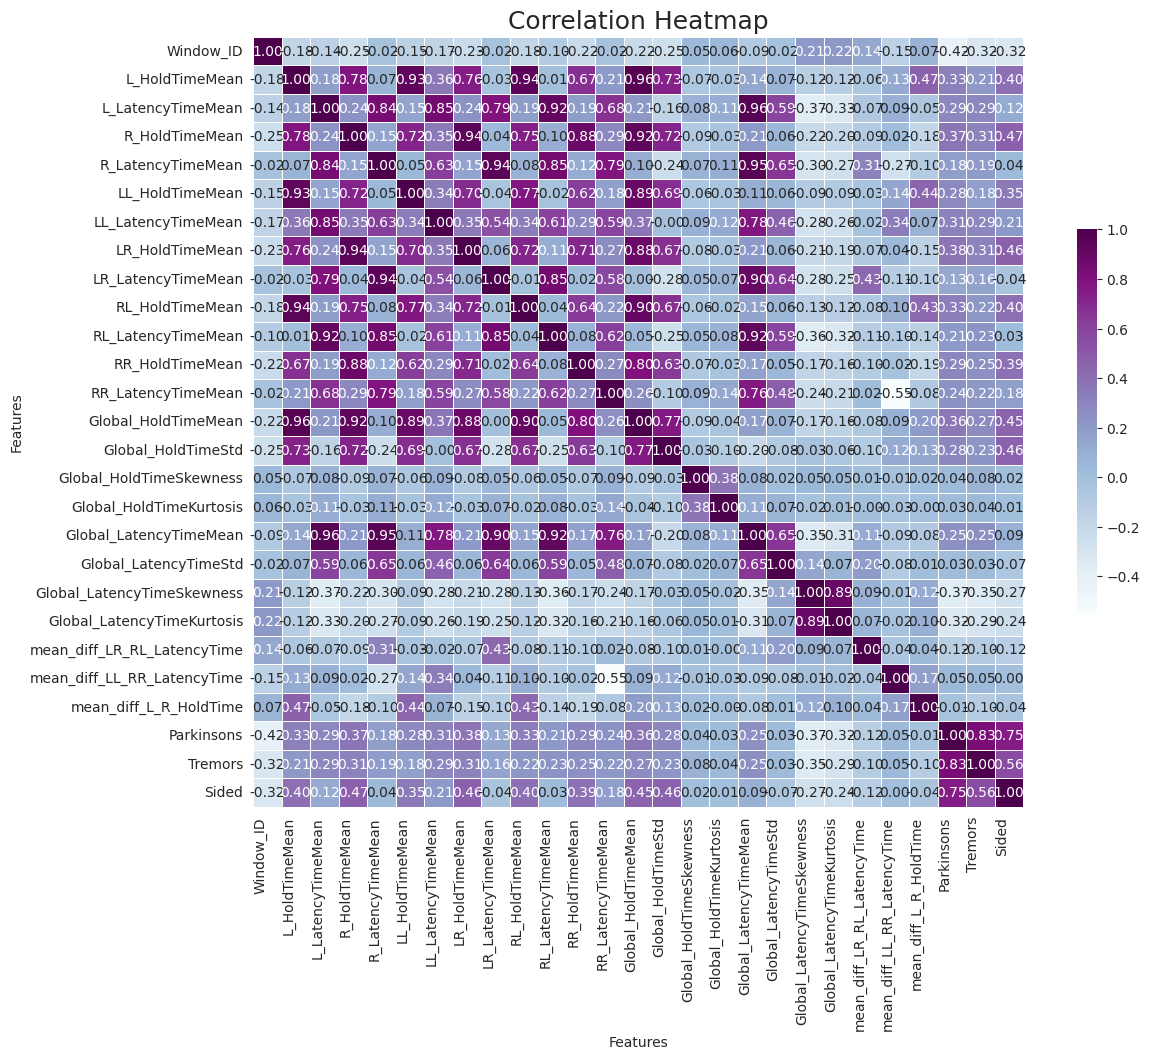

In [ ]:
# Correlation Heatmap for numerical columns

numerical_columns = final_df.select_dtypes(include=['float64', 'int64']).columns

# Calculate correlation matrix
correlation_matrix = final_df[numerical_columns].corr()

plt.figure(figsize=(14, 10))

#define colormap
cmap = sns.color_palette('BuPu', n_colors=5, as_cmap=True)

sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap', fontsize=18)
plt.xlabel('Features', fontsize=10)
plt.ylabel('Features', fontsize=10)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.show()

From the heat map we can observe correlation between the features. High correlations (above 0.7 or below -0.7) tells that one feature significantly influences the other, while a lower correlation (below 0.3 or above -0.3) suggests they have less impact on each other.

What is most important is high correlation with label (Parkinsons).

As shown in correlation heat map, we can see that there are **features thah are highly correlated between tham but lowely correlated with the label column**. This shows that neither of them is strongly related to the label, so they don't add much predictive power to the model. There are several steps that can be applyed to resolve this issues:
  1. Remove Redundant Features - remove one of the similar features
  2. Principal Component Analysis (PCA) - can help by transforming the correlated features into a smaller set of uncorrelated components.
  3. Using Regularization -  can help in feature selection by penalizing less important features
  4. Select K-Best - select most important features by using score
  5. Cross-validaion - cross-validation to evaluate the impact of including or excluding these features

# Machine Learning Model Training



In this section, we will be using this Machine Learning Models:

* Decision Tree Classifier

* Random Forest Classifier

* AdaBoost Classifier

* XGBoost Classifier

* Voting Ensemble

About the evaluation metrics, because this is a medical dataset for medical diagnosis to detect the probability of a patient having Parkinson's disease based on the provided input data. Given the medical nature of the task, it's crucial to consider evaluation metrics that capture different aspects of model performance, particularly focusing on the positive class (Parkinson's detected) due to its higher importance. Additionally, false negatives are particularly costly in diseases with limited treatment options like Parkinson's.
For that reason we are going to use all of the metrics, but giving more credit to **f1 score** and **recall(sensitivity)**.

**Accuracy** - measures how often a machine learning model correctly predicts the outcome.The Accuracy score is calculated by dividing the number of correct predictions by the total prediction number.

**F1 score**  - is the harmonic mean of precision and recall.The F1 score is particularly valuable when the positive class (e.g., detecting Parkinson's disease) is of greater interest, but both false positives and false negatives carry a significant cost.

**Precission** - The proportion of true positive predictions out of all positive predictions. High precision indicates a low rate of false positives.

**Recall** - The proportion of true positive predictions out of all actual positives. A high recall ensures that most patients with the disease are identified, which is crucial for timely treatment and intervention. Missing a diagnosis can lead to delayed treatment and worse health outcomes.

### Preparation of data

In the further analysis we will drop columns **Tremors** and **Sided** because it will help in creating a model that learns from keystroke data and does not rely on these obvious indicators, thus improving the quality and reliability of our predictive model.

**Using these columns, our model achieved 99% accuracy on both the test and validation datasets, and 100% accuracy on the training dataset. However, the learning curve indicated overfitting on the training data.**

In [6]:
# Split dataset on features(X) and target(y) variables
X = final_df.drop(columns=['Parkinsons','UserKey','Window_ID','Tremors','Sided'])
y = final_df['Parkinsons']

In [7]:
# Split on train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    shuffle=True, stratify=y, random_state=42)

print('Train size:', X_train.shape,y_train.shape)
print('Test size:', X_test.shape,y_test.shape)

Train size: (1738189, 23) (1738189,)
Test size: (744939, 23) (744939,)


## Model Training and Hyperparameter Optimization

In the following step, we will use Bayesian optimization to tune the hyperparameters of our models.

For feature selection, we will use SelectKBest. Although we experimented with PCA and other methods, SelectKBest consistently yielded higher scores.

The provided code examples are specifically designed for a **dataset with 30 keystrokes, a step size of 1, and a time window of 5 minutes**.

### Decision Tree Classifier

In [ ]:
#Define parameters grid
dt_param_grid_bo = {
    'select_k_best__k': hp.choice('select_k_best__k', list(np.arange(5, 24, 1))),
    'model__max_depth': hp.choice('model__max_depth', list(np.arange(1, 10, 1)) + [None]),
    'model__criterion': hp.choice('model__criterion', ['gini', 'entropy']),
    'model__min_samples_split': hp.choice('model__min_samples_split', list(np.arange(2, 20))),
    'model__min_samples_leaf': hp.choice('model__min_samples_leaf', list(np.arange(1, 20))),
    'model__max_features': hp.choice('model__max_features', ['auto', 'sqrt', 'log2', None])}

# Define models, model names
models = [DecisionTreeClassifier(random_state=42)]
models_names = ['DecisionTree_Clf']
models_params = [dt_param_grid_bo]

# Define KFold cross validation
cv = KFold(n_splits=5,random_state=42,shuffle=True)

# Define the objective function
def objective(space):
    base_pipe_grid_dt.set_params(**space)
    score = cross_val_score(base_pipe_grid_dt, X_train, y_train, cv=cv,
                            scoring='accuracy', n_jobs=-1).mean()

    return {'loss': -score, 'parms':space, 'status': STATUS_OK}

# Iterate
for model_name, model, model_params in zip(models_names, models, models_params):
    print('Currently fitting:', model_name)

    base_pipe_grid_dt = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('select_k_best', SelectKBest(f_classif)),
        ('model', model)
    ])

    trials = Trials()
    best_params_dt = fmin(fn=objective, space=model_params,
                          algo=tpe.suggest, max_evals=15, trials=trials)

    best_score = 0
    for trial in trials.trials:
        best_score = max(best_score, -trial['result']['loss'])

    print('Search finished, best parameters:')
    print(space_eval(model_params, best_params_dt))
    print('Best score:', best_score)

    # Set the best parameters to the pipeline
    base_pipe_grid_dt.set_params(**space_eval(model_params, best_params_dt))

    # Fit the pipeline on the entire training set
    base_pipe_grid_dt.fit(X_train, y_train)

    # Save the trained model
    joblib.dump(base_pipe_grid_dt, f'{model_name}_best_model.pkl')

Currently fitting: DecisionTree_1
100%|██████████| 15/15 [08:53<00:00, 35.60s/trial, best loss: -0.8027150529969335]
Search finished, best parameters:
{'model__criterion': 'gini', 'model__max_depth': 9, 'model__max_features': 'auto', 'model__min_samples_leaf': 14, 'model__min_samples_split': 18, 'select_k_best__k': 10}
Best score: 0.8027150529969335


### XGBoost Classifier

In [ ]:
# Define parameters grid
xgb_param_grid_bo = {
    'select_k_best__k': hp.choice('select_k_best__k', list(np.arange(5, 24, 1))),
    'model__n_estimators': hp.choice('model__n_estimators', range(10, 101, 10)),
    'model__max_depth': hp.choice('model__max_depth', list(np.arange(1, 10, 1)) + [None]),
    'model__learning_rate': hp.choice('model__learning_rate', np.arange(0.01, 1.1, 0.1)),
    'model__gamma': hp.choice('model__gamma', np.arange(0.0, 0.5, 0.1)),
    'model__reg_alpha': hp.choice('model__reg_alpha', np.logspace(-4, 1, 6)),
    'model__reg_lambda': hp.choice('model__reg_lambda', np.logspace(-4, 1, 6))}

# Define models, model names
models = [XGBClassifier(random_state=42)]
models_names = ['XGBoostClf']
models_params = [xgb_param_grid_bo]

# Define KFold cross validation
cv = KFold(n_splits=5,random_state=42,shuffle=True)

# Define the objective function
def objective(space):
    base_pipe_grid.set_params(**space)
    score = cross_val_score(base_pipe_grid, X_train, y_train, cv=cv,
                            scoring='accuracy', n_jobs=-1).mean()
    return {'loss': -score, 'status': STATUS_OK}


#Iterate
for model_name, model, model_params in zip(models_names, models, models_params):
    print('Currently fitting:', model_name)

    base_pipe_grid = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('select_k_best', SelectKBest(f_classif)),
        ('model', model)
    ])

    trials = Trials()
    best_params_xgb = fmin(fn=objective, space=model_params, algo=tpe.suggest, max_evals=20, trials=trials)

    best_score = 0
    for trial in trials.trials:
        best_score = max(best_score, -trial['result']['loss'])

    print('Search finished, best parameters:')
    print(space_eval(xgb_param_grid_bo, best_params_xgb))
    print('Best score:', best_score)

    # Set the best parameters to the pipeline
    base_pipe_grid.set_params(**space_eval(xgb_param_grid_bo, best_params_xgb))

    # Fit the pipeline on the entire training set
    base_pipe_grid.fit(X_train, y_train)

    # Save the trained model
    joblib.dump(base_pipe_grid, f'{model_name}_best_model.pkl')

Currently fitting: XGBoostClf
100%|██████████| 20/20 [28:03<00:00, 84.17s/trial, best loss: -0.8965946537396221]
Search finished, best parameters:
{'model__gamma': 0.30000000000000004, 'model__learning_rate': 0.51, 'model__max_depth': 7, 'model__n_estimators': 80, 'model__reg_alpha': 0.01, 'model__reg_lambda': 0.0001, 'select_k_best__k': 20}
Best score: 0.8965946537396221


### Random Forest Classifier

In [ ]:
#Define parameters grid
rf_param_grid_bo = {
    'select_k_best__k': hp.choice('select_k_best__k', list(np.arange(10, 20, 1))),
    'model__n_estimators': hp.choice('model__n_estimators', range(50, 200, 10)),
    'model__max_depth': hp.choice('model__max_depth', list(np.arange(1, 10, 1))),
    'model__criterion': hp.choice('model__criterion', ['gini', 'entropy']),
    'model__min_samples_split': hp.choice('model__min_samples_split', list(np.arange(2, 10, 1))),
    'model__min_samples_leaf': hp.choice('model__min_samples_leaf', list(np.arange(1, 10, 1))),
    'model__max_features': hp.choice('model__max_features', ['auto', 'sqrt', None])}

# Define models
models = [RandomForestClassifier(random_state=42,n_jobs=-1)]

# Model names
models_names = ['RandomForest_30']

# Model parameters in a list
models_params = [rf_param_grid_bo]

cv = KFold(n_splits=2, random_state=42, shuffle=True)

# Define the objective function
def objective(space):
    base_pipe_grid.set_params(**space)
    score = cross_val_score(base_pipe_grid, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return {'loss': -score, 'status': STATUS_OK}


#Iterate
for model_name, model, model_params in zip(models_names, models, models_params):
    print('Currently fitting:', model_name)

    base_pipe_grid = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('select_k_best', SelectKBest(f_classif)),
        ('model', model)
    ])

    trials = Trials()
    best_params_rf = fmin(fn=objective, space=model_params, algo=tpe.suggest, max_evals=10, trials=trials)

    best_score = 0
    for trial in trials.trials:
        best_score = max(best_score, -trial['result']['loss'])

    print('Search finished, best parameters:')
    print(space_eval(rf_param_grid_bo, best_params_rf))
    print('Best score:', best_score)

    # Set the best parameters to the pipeline
    base_pipe_grid.set_params(**space_eval(rf_param_grid_bo, best_params_rf))

    # Fit the pipeline on the entire training set
    base_pipe_grid.fit(X_train, y_train)

    # Save the trained model
    joblib.dump(base_pipe_grid, f'{model_name}_best_model.pkl')

Currently fitting: RandomForest_30
100%|██████████| 10/10 [1:12:00<00:00, 432.02s/trial, best loss: -0.8450323870950326]
Search finished, best parameters:
{'model__criterion': 'entropy', 'model__max_depth': 9, 'model__max_features': 'auto', 'model__min_samples_leaf': 1, 'model__min_samples_split': 9, 'model__n_estimators': 80, 'select_k_best__k': 15}
Best score: 0.8450323870950326


### AdaBoost Classifier

In [ ]:
#Define parameters grid
adb_param_grid_bo = {'select_k_best__k': hp.choice('select_k_best__k', list(np.arange(5, 24, 1))),
                     'model__n_estimators': hp.choice('model__n_estimators', np.arange(10, 100, 10)),
                     'model__learning_rate': hp.choice('model__learning_rate', np.arange(0.5, 1.1, 0.1))}

# Define models, model names
models = [AdaBoostClassifier(random_state = 42)]

models_names = ['AdaBoost']

models_params = [adb_param_grid_bo]

# Define KFold cross validation
cv = KFold(n_splits=2,random_state=42,shuffle=True)

# Define the objective function
def objective(space):
    base_pipe_grid.set_params(**space)
    score = cross_val_score(base_pipe_grid, X_train, y_train, cv=cv,
                            scoring='accuracy', n_jobs=-1).mean()
    return {'loss': -score, 'status': STATUS_OK}


#Iterate
for model_name, model, model_prams in zip(models_names, models, models_params):
    print('Currently fitting:', model_name)

    base_pipe_grid = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('select_k_best', SelectKBest(f_classif)),
        ('model', model)
    ])

    trials = Trials()
    best_params_adb = fmin(fn=objective, space=model_prams, algo=tpe.suggest,
                           max_evals=10, trials=trials)

    best_score = 0
    for trial in trials.trials:
        best_score = max(best_score, -trial['result']['loss'])

    print('Search finished, best parameters:')
    print(space_eval(adb_param_grid_bo, best_params_adb))
    print('Best score:', best_score)

    # Set the best parameters to the pipeline
    base_pipe_grid.set_params(**space_eval(adb_param_grid_bo, best_params_adb))

    # Fit the pipeline on the entire training set
    base_pipe_grid.fit(X_train, y_train)

    # Save the trained model
    joblib.dump(base_pipe_grid, f'{model_name}_best_model.pkl')

Currently fitting: AdaBoost
100%|██████████| 10/10 [38:18<00:00, 229.88s/trial, best loss: -0.7839555757121004]
Search finished, best parameters:
{'model__learning_rate': 0.8999999999999999, 'model__n_estimators': 70, 'select_k_best__k': 15}
Best score: 0.7839555757121004


### Voting Classifier

We experimented with a voting classifier using the top three models and then with the top two models. For further analysis, we used the voting classifier that achieved the higher score.

In [ ]:
# Load models
dt_model = joblib.load('DecisionTreeClf_best_model.pkl')
xgb_model = joblib.load('XGBoostClf_best_model.pkl')
rf_model = joblib.load('RandomForest_30_best_model.pkl')

# Create a voting classifier with the 3 best models
voting_clf = VotingClassifier(
    estimators=[('dt', dt_model), ('xgb', xgb_model), ('rf', rf_model)],
    voting='soft' )

# Fit the voting classifier
voting_clf.fit(X_train,y_train)

# Score
print('Score on training data:', voting_clf.score(X_train,y_train))
print('Score on testing data:', voting_clf.score(X_test,y_test))

Score on training data: 0.8836760559409822
Score on testing data: 0.8800921954683538


In [ ]:
# Create a voting classifier with the two best models
voting_clf3 = VotingClassifier(
    estimators=[('dt', dt_model), ('xgb', xgb_model)],
    voting='soft' )

# Fit the voting classifier
voting_clf3.fit(X_train,y_train)

# Score
print('Score on training data:', voting_clf3.score(X_train,y_train))
print('Score on testing data:', voting_clf3.score(X_test,y_test))

Score on training data: 0.8903134239142003
Score on testing data: 0.8854429691558637


### Models Evaluation

In [ ]:
# Function to generate model metrics
def generate_classification_reports(models, X_train, X_test, y_train, y_test):
    reports = []
    for model_name, model in models.items():
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        train_report = classification_report(y_train, y_pred_train, digits=4, output_dict=True)
        test_report = classification_report(y_test, y_pred_test, digits=4, output_dict=True)

        # Extracting metrics
        train_accuracy = round(train_report['accuracy'], 5)
        train_precision = round(train_report['weighted avg']['precision'], 5)
        train_f1_score = round(train_report['weighted avg']['f1-score'], 5)
        train_recall = round(train_report['weighted avg']['recall'], 5)

        test_accuracy = round(test_report['accuracy'], 5)
        test_precision = round(test_report['weighted avg']['precision'], 5)
        test_f1_score = round(test_report['weighted avg']['f1-score'], 5)
        test_recall = round(test_report['weighted avg']['recall'], 5)

        # Appending to the reports list
        reports.append([
            model_name,train_accuracy, train_precision, train_f1_score, train_recall,
            test_accuracy, test_precision, test_f1_score, test_recall])

    return reports

### 30 keystrokes dataset
This dataset has 2483128 instances

In [ ]:
# Load models
dt_model = joblib.load('DecisionTreeClf_best_model.pkl')
xgb_model = joblib.load('XGBoostClf_best_model.pkl')
rf_model = joblib.load('RandomForest_30_best_model.pkl')
ada_model = joblib.load('AdaBoost_best_model.pkl')
voting_clf = joblib.load('votingclf_best.pkl')

# Model names
models = {
    'Decision Tree': dt_model,
    'XGBoost': xgb_model,
    'Random Forest': rf_model,
    'AdaBoost': ada_model,
    'VotingClf': voting_clf}

# Get classification reports
reports = generate_classification_reports(models, X_train, X_test, y_train, y_test)

# Define table headers
headers = ['Model', 'Train \n Accuracy', 'Train \n Precision', 'Train \n F1', 'Train \n Recall',
           'Test \n Accuracy', 'Test \n Precision', 'Test \n F1', 'Test \n Recall']

# Print the table
print(tabulate(reports, headers=headers, tablefmt='grid'))

+---------------+-------------+--------------+----------+-----------+-------------+--------------+---------+-----------+
| Model         |      Train  |       Train  |   Train  |    Train  |       Test  |        Test  |   Test  |     Test  |
|               |    Accuracy |    Precision |       F1 |    Recall |    Accuracy |    Precision |      F1 |    Recall |
+===============+=============+==============+==========+===========+=============+==============+=========+===========+
| Decision Tree |     0.84157 |      0.84142 |  0.8414  |   0.84157 |     0.84187 |      0.84172 | 0.84171 |   0.84187 |
+---------------+-------------+--------------+----------+-----------+-------------+--------------+---------+-----------+
| XGBoost       |     0.90113 |      0.9011  |  0.90111 |   0.90113 |     0.89904 |      0.89902 | 0.89903 |   0.89904 |
+---------------+-------------+--------------+----------+-----------+-------------+--------------+---------+-----------+
| Random Forest |     0.84551 | 

______________
### Below, we present the outcomes achieved through training models using datasets containing 50 keystrokes with a step size of 1 and a time window of 5 minutes, as well as dataset containing 100 keystrokes with the same step size and time window.

### 50 keystrokes dataset

This dataset has 2169680 instances

In [8]:
# Load dataset
file_path = '/content/drive/MyDrive/Final Project/final50keystrokes.csv'

# Read the file
final_50_df = pd.read_csv(file_path)

# Shape
final_50_df.shape

(2169680, 28)

In [9]:
# Split on X,y
X_50 = final_50_df.drop(columns=['Parkinsons','Tremors','Sided','Window_ID','UserKey'])
y_50 = final_50_df['Parkinsons']

# Split on train-test
X_50_train, X_50_test, y_50_train,y_50_test = train_test_split(X_50, y_50,shuffle=True,
                                                               random_state=42,stratify=y_50)

In [ ]:
# Load models trained on 50 keystrokes dataset
dt_50_model = joblib.load('DecisionTreeClf_50_best_model.pkl')
xgb_50_model = joblib.load('XGBoostClf_50_best_model.pkl')
rf_50_model = joblib.load('RandomForestClf_50_best_model.pkl')

# Model names
models_50 = {
    'Decision Tree': dt_50_model,
    'XGBoost': xgb_50_model,
    'Random Forest': rf_50_model}

# Get classification reports
reports_50 = generate_classification_reports(models_50, X_50_train, X_50_test,
                                             y_50_train, y_50_test)

# Define table headers
headers = ['Model', 'Train \n Accuracy', 'Train \n Precision', 'Train \n F1', 'Train \n Recall',
           'Test \n Accuracy', 'Test \n Precision', 'Test \n F1', 'Test \n Recall']

# Print the table
print(tabulate(reports_50, headers=headers, tablefmt='grid'))

+---------------+-------------+--------------+----------+-----------+-------------+--------------+---------+-----------+
| Model         |      Train  |       Train  |   Train  |    Train  |       Test  |        Test  |   Test  |     Test  |
|               |    Accuracy |    Precision |       F1 |    Recall |    Accuracy |    Precision |      F1 |    Recall |
+===============+=============+==============+==========+===========+=============+==============+=========+===========+
| Decision Tree |     0.90196 |      0.9019  |  0.90175 |   0.90196 |     0.89578 |      0.89569 | 0.89556 |   0.89578 |
+---------------+-------------+--------------+----------+-----------+-------------+--------------+---------+-----------+
| XGBoost       |     0.95995 |      0.95994 |  0.95994 |   0.95995 |     0.95097 |      0.95094 | 0.95095 |   0.95097 |
+---------------+-------------+--------------+----------+-----------+-------------+--------------+---------+-----------+
| Random Forest |     0.91596 | 

### 100 keystrokes dataset

This dataset has 1493712 instances

In [10]:
# Load Dataset
file_path = '/content/drive/MyDrive/Final Project/final_100keystrokes.csv'

# Read the file
final_100_df = pd.read_csv(file_path)

# Shape
final_100_df.shape

(1493712, 28)

In [11]:
# Split on X,y
X_100 = final_100_df.drop(columns=['Parkinsons','Tremors','Sided','Window_ID','UserKey'])
y_100 = final_100_df['Parkinsons']

# Split on train-test
X_100_train, X_100_test, y_100_train,y_100_test = train_test_split(X_100, y_100,shuffle=True,
                                                                   random_state=42,stratify=y_100)

In [ ]:
# Load models trained on dataset with 100 keystrokes
dt_100_model = joblib.load('DecisionTree_100_best_model.pkl')
xgb_100_model = joblib.load('XGBoost_100_best_model.pkl')
rf_100_model = joblib.load('RandomForest_100_best_model.pkl')
ada_100_model = joblib.load('AdaBoost_100_best_model.pkl')

# Model names
models_100 = {
    'Decision Tree': dt_100_model,
    'XGBoost': xgb_100_model,
    'Random Forest': rf_100_model,
    'AdaBoost': ada_100_model}

# Get classification reports
reports_100 = generate_classification_reports(models_100, X_100_train, X_100_test, y_100_train,y_100_test)

# Define table headers
headers = ['Model', 'Train \n Accuracy', 'Train \n Precision', 'Train \n F1', 'Train \n Recall',
           'Test \n Accuracy', 'Test \n Precision', 'Test \n F1', 'Test \n Recall']

# Print the table
print(tabulate(reports_100, headers=headers, tablefmt='grid'))

+---------------+-------------+--------------+----------+-----------+-------------+--------------+---------+-----------+
| Model         |      Train  |       Train  |   Train  |    Train  |       Test  |        Test  |   Test  |     Test  |
|               |    Accuracy |    Precision |       F1 |    Recall |    Accuracy |    Precision |      F1 |    Recall |
+===============+=============+==============+==========+===========+=============+==============+=========+===========+
| Decision Tree |     0.95339 |      0.95327 |  0.95327 |   0.95339 |     0.95271 |      0.95259 | 0.95258 |   0.95271 |
+---------------+-------------+--------------+----------+-----------+-------------+--------------+---------+-----------+
| XGBoost       |     0.95234 |      0.95357 |  0.9526  |   0.95234 |     0.95208 |      0.9533  | 0.95235 |   0.95208 |
+---------------+-------------+--------------+----------+-----------+-------------+--------------+---------+-----------+
| Random Forest |     0.94608 | 

# Choosing Best Model and Making Predictions

### Best model

In [16]:
# List of models and their names
models = {
    'DecisionTree_30': dt_model,
    'XGBoost_30': xgb_model,
    'RandomForest_30': rf_model,
    'AdaBoost_30' : ada_model,
    'DecisionTree_50' : dt_50_model,
    'XGBoost_50': xgb_50_model,
    'RandomForest_50': rf_50_model,
    'DecisionTree_100' : dt_100_model,
    'XGBoost_100': xgb_100_model,
    'RandomForest_100': rf_100_model,
    'AdaBoost_100' : ada_100_model}

# Function to extract metrics from the classification report
def get_metrics(report_dict, prefix):
    metrics = {}
    for key in ['precision', 'recall', 'f1-score']:
        metrics[f"{prefix} {key}"] = [
            report_dict['Class 0'][key],
            report_dict['Class 1'][key]
        ]

    metrics[f'{prefix} Accuracy'] = [
        report_dict['accuracy'],
        report_dict['accuracy']
    ]
    return metrics

# Evaluate each model and collect the metrics
data = []
for model_name, model in models.items():
    y_pred_train = model.predict(X_train)
    report_dict_train = classification_report(y_train, y_pred_train,
                                              target_names=['Class 0', 'Class 1'], output_dict=True)

    y_pred_test = model.predict(X_test)
    report_dict_test = classification_report(y_test, y_pred_test,
                                             target_names=['Class 0', 'Class 1'], output_dict=True)

    metrics_train = get_metrics(report_dict_train, 'Train')
    metrics_test = get_metrics(report_dict_test, 'Test')

    # Aggregate metrics into a list for the DataFrame
    for class_idx in range(2):
        data.append({
            'Model': model_name,
            'Class': f'Class {class_idx}',
            'Train Precision': metrics_train['Train precision'][class_idx],
            'Train Recall': metrics_train['Train recall'][class_idx],
            'Train F1-Score': metrics_train['Train f1-score'][class_idx],
            'Test Precision': metrics_test['Test precision'][class_idx],
            'Test Recall': metrics_test['Test recall'][class_idx],
            'Test F1-Score': metrics_test['Test f1-score'][class_idx]
        })

df = pd.DataFrame(data)

# Find the best model based on test F1-score
best_model_row = df.loc[df['Test F1-Score'].idxmax()]

# Highlight the best model
best_model_name = best_model_row['Model']
best_model_class = best_model_row['Class']

fig = go.Figure()

# Add traces for each model and class
for model_name in models.keys():
    for class_name in ['Class 0', 'Class 1']:
        filtered_df = df[(df['Model'] == model_name) & (df['Class'] == class_name)]
        fig.add_trace(go.Scatter3d(
            x=filtered_df['Test Precision'],
            y=filtered_df['Test Recall'],
            z=filtered_df['Test F1-Score'],
            mode='markers',
            marker=dict(size=8, opacity=0.8, line=dict(width=2)),
            name=f'{model_name} - {class_name}'
        ))

# Highlight the best model
best_model_df = df[(df['Model'] == best_model_name) & (df['Class'] == best_model_class)]

fig.add_trace(go.Scatter3d(
    x=best_model_df['Test Precision'],
    y=best_model_df['Test Recall'],
    z=best_model_df['Test F1-Score'],
    mode='markers',
    marker=dict(size=10, color='red', opacity=0.9, line=dict(width=3)),
    name=f'{best_model_name} (Best Model)'
))

# Update layout with larger background and shadows
fig.update_layout(
    title='Model Evaluation Metrics',
    scene=dict(
        xaxis=dict(title='Precision'),
        yaxis=dict(title='Recall'),
        zaxis=dict(title='F1-Score'),
        camera=dict(
            eye=dict(x=1.25, y=1.25, z=1.25)
        ),
        aspectratio=dict(x=1.5, y=1.5, z=1.5)
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Update colors for better visibility
fig.update_layout(
    font=dict(color='#666666'),  # Medium gray color
    title_font=dict(color='#666666'),
    scene=dict(
        xaxis=dict(title=dict(text='Precision', font=dict(color='#666666')), tickfont=dict(color='#666666')),
        yaxis=dict(title=dict(text='Recall', font=dict(color='#666666')), tickfont=dict(color='#666666')),
        zaxis=dict(title=dict(text='F1-Score', font=dict(color='#666666')), tickfont=dict(color='#666666'))),
    legend=dict(font=dict(color='#666666'))
)
fig.show()

#### When evaluating all models on the entire dataset generated from 30 keystrokes, we observe that the XGBoost model trained on dataset from 30 keystrokes outperforms others with the highest score.

#### Models trained on larger datasets generally perform better due to having more data to learn from. To demonstrate this, we'll conduct a real-world test case scenario. We generated a keystroke logger tool where users can input their username and type something (ex. how was their day). This tool records their hold time, latency time, hand, and direction.

#### For testing purposes, we'll enlist one participant with Parkinson's disease and another without Parkinson's disease. This real-world test will provide valuable insights into how well the models generalize to new data and whether they can accurately distinguish between users with and without Parkinson's disease.

In [30]:
from IPython.display import HTML

In [32]:
# This is the keystroke logger we created (it can be open in browser too)

# Path to the uploaded HTML file
file_path = '/content/drive/MyDrive/Final Project/keystroke_logger.html'

# Read the HTML file
with open(file_path, 'r') as file:
    html_content = file.read()

# Display the HTML content
display(HTML(html_content))

Key,Hand,Direction,Hold Time (ms),Latency Time (ms)


### Predictions

In [18]:
# Load csv files
user_1 = pd.read_csv('keystroke_log_user1.csv')
user_2 = pd.read_csv('keystroke_log_user2.csv')

In [ ]:
# Nan values for both users
print('User1 Nan values:', user_1.isna().sum().sum())
print('User2 Nan values:', user_2.isna().sum().sum())

User1 Nan values: 2
User2 Nan values: 2


In [19]:
# Drop Nan values
user_1 = user_1.dropna()
user_2 = user_2.dropna()

In [20]:
# Cleaning user_1 data because it contains Unknown values for backspace and because it contains values for space
user_1 = user_1[~user_1['direction'].str.contains('Unknown')]
user_1 = user_1[~((user_1['hand'] == 'S') | (user_1['direction'].str.contains('S')))]

In [21]:
# Cleaning user_2 data because it contains Unknown values for backspace and because it contains values for space
user_2 = user_2[~user_2['direction'].str.contains('Unknown')]
user_2 = user_2[~((user_2['hand'] == 'S') | (user_2['direction'].str.contains('S')))]

In [ ]:
# Shape of both data
print('Shape of user1 data:' ,user_1.shape)
print('Shape of user2 data:' ,user_2.shape)

Shape of user1 data: (58, 6)
Shape of user2 data: (81, 6)


In [22]:
def preprocess_testing_data(tappy_data, keystroke_window=30):
    results = []

    for i in range(0, len(tappy_data) - keystroke_window + 1):
        window_data = tappy_data.iloc[i:i+keystroke_window]

        window_stats = {}

        # Group by hand
        hand_means = window_data.groupby('hand')[['holdTime', 'latencyTime']].mean()
        for hand in ['L', 'R']:
            if hand in hand_means.index:
                window_stats[f'{hand}_HoldTimeMean'] = hand_means.loc[hand, 'holdTime']
                window_stats[f'{hand}_LatencyTimeMean'] = hand_means.loc[hand, 'latencyTime']

        # Group by direction
        direction_means = window_data.groupby('direction')[['holdTime', 'latencyTime']].mean()
        for direction in ['LL', 'LR', 'RL', 'RR']:
            if direction in direction_means.index:
                window_stats[f'{direction}_HoldTimeMean'] = direction_means.loc[direction, 'holdTime']
                window_stats[f'{direction}_LatencyTimeMean'] = direction_means.loc[direction, 'latencyTime']

        # Calculate global statistics
        window_stats['Global_HoldTimeMean'] = window_data['holdTime'].mean()
        window_stats['Global_HoldTimeStd'] = window_data['holdTime'].std()
        window_stats['Global_HoldTimeSkewness'] = skew(window_data['holdTime'])
        window_stats['Global_HoldTimeKurtosis'] = kurtosis(window_data['holdTime'])
        window_stats['Global_LatencyTimeMean'] = window_data['latencyTime'].mean()
        window_stats['Global_LatencyTimeStd'] = window_data['latencyTime'].std()
        window_stats['Global_LatencyTimeSkewness'] = skew(window_data['latencyTime'])
        window_stats['Global_LatencyTimeKurtosis'] = kurtosis(window_data['latencyTime'])

        # Calculate mean differences
        window_stats['mean_diff_LR_RL_LatencyTime'] = (window_stats.get('LR_LatencyTimeMean', 0) -
                                                       window_stats.get('RL_LatencyTimeMean', 0))
        window_stats['mean_diff_LL_RR_LatencyTime'] = (window_stats.get('LL_LatencyTimeMean', 0) -
                                                       window_stats.get('RR_LatencyTimeMean', 0))
        window_stats['mean_diff_L_R_HoldTime'] = (window_stats.get('L_HoldTimeMean', 0) -
                                                  window_stats.get('R_HoldTimeMean', 0))

        results.append(window_stats)

    return pd.DataFrame(results)

# Apply sliding window
user_1_df = preprocess_testing_data(user_1, keystroke_window=30)
user_2_df = preprocess_testing_data(user_2, keystroke_window=30)

In [23]:
# Using best model to predict if this users have or have not Parkinsons disease
best_model = joblib.load('XGBoostClf_best_model.pkl')

predictions_user_1 = best_model.predict(user_1_df)
predictions_user_2 = best_model.predict(user_2_df)

# Define function that will evaluate model predictions
def evaluate_predictions(predictions):
    count_1 = sum(predictions == 1)
    count_0 = sum(predictions == 0)
    if count_1 > count_0:
        return True
    else:
        return False

# Evaluate predictions for each user
prediction_user_1_result = evaluate_predictions(predictions_user_1)
prediction_user_2_result = evaluate_predictions(predictions_user_2)

# Print the predictions for each user
print("Prediction for user 1:", prediction_user_1_result)
print("Prediction for user 2:", prediction_user_2_result)

Prediction for user 1: True
Prediction for user 2: False


#### The predictions we achivied with this model are True.

### Conclusion

The models developed in this project exhibit significant potential for aiding in the early detection of Parkinson's disease through keystroke dynamics analysis. The XGBoost model, in particular, stands out for its high scores and robustness. With further development and validation, these models could become valuable tools for healthcare professionals, offering a cost-effective and accessible means of monitoring and diagnosing Parkinson's disease.